In [1]:
import pyedflib
import numpy as np

import torchvision
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

from IPython.display import clear_output
from tqdm import tqdm
import matplotlib.ticker as ticker
from scipy.ndimage import gaussian_filter
%matplotlib inline

In [2]:
file_name = "./data/chb01_03.edf"
f = pyedflib.EdfReader(file_name)
n = f.signals_in_file
signal_labels = f.getSignalLabels()
sigbufs = np.zeros((n, f.getNSamples()[0]))
for i in np.arange(n):
        sigbufs[i, :] = f.readSignal(i)

In [3]:
sr = 256
batch_size = 64
preictal_time = 20 * 60 * sr

siez_starts = [2996, 1467, 1732, 1015, 1720, 327, 1862]
siez_starts = [siez_starts[i] * sr for i in range(len(siez_starts))]
siez_ends = [3036, 1494, 1772, 1066, 1810, 420, 1963]
siez_ends = [siez_ends[i] * sr for i in range(len(siez_ends))]
file_names = ["chb01_03.edf", "chb01_04.edf", "chb01_15.edf", "chb01_16.edf", "chb01_18.edf", "chb01_21.edf", "chb01_26.edf"]

In [4]:
data = sigbufs
data = gaussian_filter(data, sigma=3, radius=5)
lstm_train = data[:, :400000]
lstm_test =  data[:, 400000:500000]

mean = lstm_train.mean(axis=1)
std = lstm_train.std(axis=1)
#sigmastest = np.abs(test - mean)
train_norm = (lstm_train - mean[..., None])/std[..., None]
test_norm = (lstm_test - mean[..., None])/std[..., None]

train_norm = torch.FloatTensor(train_norm)
test_norm = torch.FloatTensor(test_norm)

In [5]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=32, num_layers=2, output_size=1, dropout=0.2):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.linear_1 = nn.Linear(input_size, hidden_layer_size)
        self.relu = nn.ReLU()
        self.lstm = nn.LSTM(hidden_layer_size, hidden_size=self.hidden_layer_size, num_layers=num_layers, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(num_layers*hidden_layer_size, output_size)
        

    def forward(self, x):
        batchsize = x.shape[0]

        # layer 1
        x = self.linear_1(x)
        x = self.relu(x)
        
        
        # LSTM layer
        lstm_out, (h_n, c_n) = self.lstm(x)

        # Floating
        

        x = h_n.permute(1, 0, 2).reshape(batchsize, -1) 

        
        # layer 2
        x = self.dropout(x)
        predictions = self.linear_2(x)
        
        return predictions

In [6]:
train_window = 20

def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = input_data.shape[-1]
    for i in range(L-tw):
        train_seq = input_data[:, i:i+tw]
        train_label = input_data[:, i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

train_inout_seq = create_inout_sequences(train_norm, train_window)
test_inout_seq = create_inout_sequences(test_norm, train_window)

In [8]:
for i in range(10):
    np.savetxt("SimulinkData/input" + str(i), test_inout_seq[i][0].numpy())
    np.savetxt("SimulinkData/output" + str(i), test_inout_seq[i][1].numpy())    

In [8]:
train_dataloader = DataLoader(train_inout_seq, batch_size=64, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_inout_seq, batch_size=64, shuffle=False, drop_last=True)

In [9]:
def GetRmse(model, val_dataloader, lstm_test, std, mean):
    model.eval()

    rmse = []
    
    lstm_predicts = []
    for k in tqdm(range(1, 20)):
        test_right_part = (len(lstm_test[0])- 20)%64
        predicted_val = np.zeros((1, 23))
        for idx, (x, y) in enumerate(val_dataloader):
            x = x.transpose(1, 2).to('cuda')
            cur_x = x
            for _ in range(k):
                out = model(cur_x.to('cuda'))
                #print(out.shape)
                #print(cur_x.shape)
                cur_x = torch.hstack((cur_x[:, 1:, :], out[..., None].transpose(1, 2)))
                #print(cur_x.shape)
            predicted_val = np.concatenate((predicted_val, cur_x[:, -1, :].cpu().detach().numpy()))
            
        lstm_predicts.append(np.array(predicted_val[1:])*std[None, ...]+mean[None, ...])
        if k == 1:
            
            r = ((((np.array(predicted_val)*std[None, ...]+mean[None, ...])[1:, 0] - np.array(lstm_test[0, 20:-test_right_part]))**2).mean())**0.5
        else:
            r = ((((np.array(predicted_val[:-k+1])*std[None, ...]+mean[None, ...])[1:, 0] - np.array(lstm_test[0, 20+k-1:-test_right_part]))**2).mean())**0.5
        rmse.append(r)
    return rmse, np.array(lstm_predicts)

In [10]:
def MAPE(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape

In [11]:
def run_epoch(model, optimizer, criterion, dataloader, is_training=False):
    epoch_loss = 0

    if is_training:
        model.train()
    else:
        model.eval()

    for idx, (x, y) in enumerate(dataloader):
        if is_training:
            optimizer.zero_grad()

        batchsize = x.shape[0]
        
        
        x = x.transpose(1, 2).to('cuda')
        #print("x", x.shape)
        y = y[:, :, -1].to('cuda')

        out = model(x)
        #print("y", y.shape)
        #print("out", out.shape)
        loss = criterion(out.contiguous(), y.contiguous())

        if is_training:
            loss.backward()
            optimizer.step()

        epoch_loss += (loss.detach().item() / len(dataloader))


    return epoch_loss

In [11]:
# define optimizer and loss function

def train(model_lstm, exp_name):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model_lstm.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-9)
    scheduler = ReduceLROnPlateau(optimizer, patience = 8, factor=0.5, min_lr=0.0001)
    lr = 0.001
    epochs = 175

    losses_train = []
    losses_test = []
    best_loss = 10e9
    # begin training
    
    early_stop_count = 15
    current_es = 0
    for epoch in range(epochs): 
        loss_train = run_epoch(model_lstm, optimizer, criterion, train_dataloader, is_training=True)
        loss_val = run_epoch(model_lstm, optimizer, criterion, test_dataloader)
        scheduler.step(loss_val)
        losses_train.append(loss_train)
        losses_test.append(loss_val)

        if losses_test[-1] < best_loss:
            current_es = 0
            best_loss = losses_test[-1]
            torch.save(model_lstm.state_dict(), "./models/LSTMChildrenSeveralLeads" + exp_name)
        else:
            current_es += 1
        if current_es == early_stop_count:
            break

        clear_output(True)
        fig = plt.figure(figsize=(10, 9))

        ax_1 = fig.add_subplot(2, 1, 1)
        ax_2 = fig.add_subplot(2, 1, 2)
        ax_1.set_title('train')
        ax_1.plot(losses_train)
        ax_2.set_title('test')
        ax_2.plot(losses_test)
        plt.show()
    
        
        print(exp_name)
        print('Epoch[{}/{}] | loss train:{:.6f}, test:{:.6f}'
                  .format(epoch+1, epochs, loss_train, loss_val))
        
    model_lstm.load_state_dict(torch.load("./models/LSTMChildrenSeveralLeads" + exp_name))
    rmse_chaos, lstm_predicts = GetRmse(model_lstm, test_dataloader, lstm_test, std, mean)
    np.save("./metrics/rmse" + exp_name, np.array(rmse_chaos))
    
    test_right_part = (len(lstm_test[0])- 20)%64
    mape_sev_lead = []
    for i in range(len(lstm_predicts)):

        if i:
            mape_sev_lead.append(MAPE(lstm_test[0, 20+i:-test_right_part], lstm_predicts[i][:-i, 0]))
        else:
            mape_sev_lead.append(MAPE(lstm_test[0, 20:-test_right_part], lstm_predicts[0, :,0]))
            
    np.save("./metrics/mape" + exp_name, np.array(mape_sev_lead))

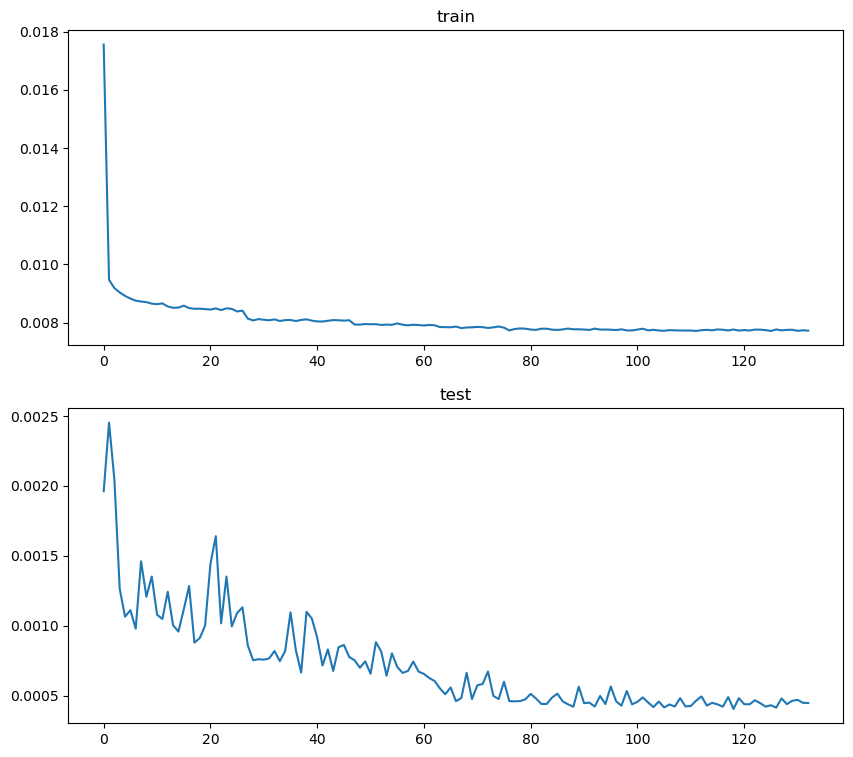

_50_2_0.2
Epoch[133/175] | loss train:0.007725, test:0.000446



100%|████████████████████████████████████████████████████████████████████████████████| 8/8 [3:37:20<00:00, 1630.04s/it]


In [15]:
hiddens = [10, 20, 30, 40, 50]
n_layers = [1, 2]
dropout = [0.1, 0.2]

params = [(h, l, dr) for h in hiddens for l in n_layers for dr in dropout]

for n_hidden, n_layers, dropout in tqdm(params[12:]):
    exp_name = "_" + str(n_hidden) + "_" + str(n_layers) + "_" + str(dropout)
    model = LSTMModel(input_size=23, hidden_layer_size=n_hidden, num_layers=n_layers, output_size=23, dropout=dropout)
    model = model.to('cuda')
    train(model, exp_name)

### Best model

In [12]:
n_hidden, n_layers, dropout = 30, 2, 0.1

exp_name = "_" + str(n_hidden) + "_" + str(n_layers) + "_" + str(dropout)
model = LSTMModel(input_size=23, hidden_layer_size=n_hidden, num_layers=n_layers, output_size=23, dropout=dropout)
model = model.to('cuda')

model.load_state_dict(torch.load("./models/LSTMChildrenSeveralLeads" + exp_name))
rmse_chaos, lstm_predicts = GetRmse(model, test_dataloader, lstm_test, std, mean)

100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [04:25<00:00, 13.95s/it]


In [13]:
np.save("./predicts/"+ exp_name, lstm_predicts)